#### Import packages and device selection

In [1]:
import gc
import os
import re
import cv2
from tqdm.notebook import tqdm
import optuna
from optuna.trial import TrialState
import torch
from torch import nn, optim
from torch.utils.checkpoint import checkpoint
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchinfo import summary
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SIZE = 160
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32  = True

In [3]:
print("Using device: ", device)

Using device:  cuda


## Dataset Loading and Preprocessing

In [4]:
def sort_files(folder):
    convert_func = lambda x: int(x) if x.isdigit() else x.lower()
    key_func = lambda x: [convert_func(c) for c in re.split('([0-9]+)', x)]
    return sorted(folder, key=key_func)

input_L = []
target_ab = []
path = '../data/color'
folder = os.listdir(path)
folder = sort_files(folder)
for file in tqdm(folder, desc='Loading color images'):
    img = cv2.imread(os.path.join(path, file), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img = cv2.resize(img, (SIZE, SIZE))
    L = img[:, :, 0:1] / 255.0 # (H, W, 1) [0..1]
    ab = img[:, :, 1:3] / 255.0 # (H, W, 2) [0..1]
    input_L.append(L)
    target_ab.append(ab)
input_L = np.array(input_L).astype(np.float32) # (N, H, W, 1)
target_ab = np.array(target_ab).astype(np.float32) # (N, H, W, 2)

Loading color images:   0%|          | 0/7129 [00:00<?, ?it/s]

In [5]:
print(input_L.shape, target_ab.shape)

(7129, 160, 160, 1) (7129, 160, 160, 2)


#### Display some samples

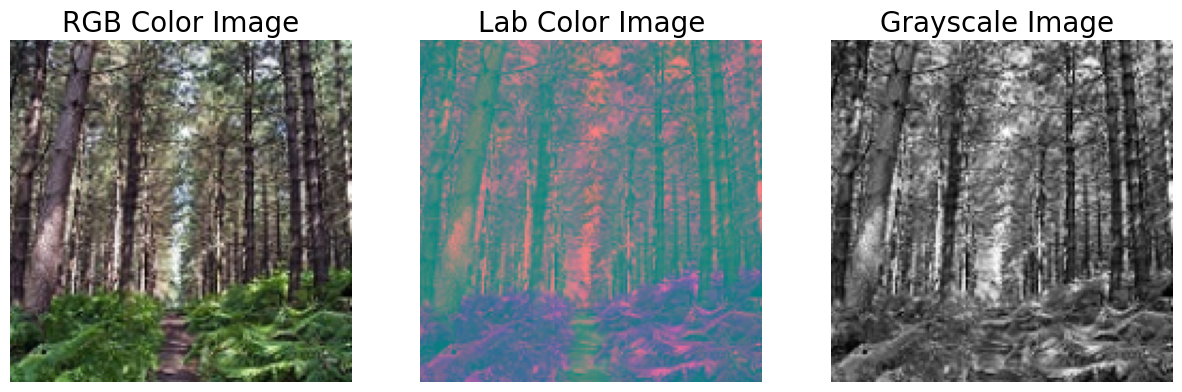

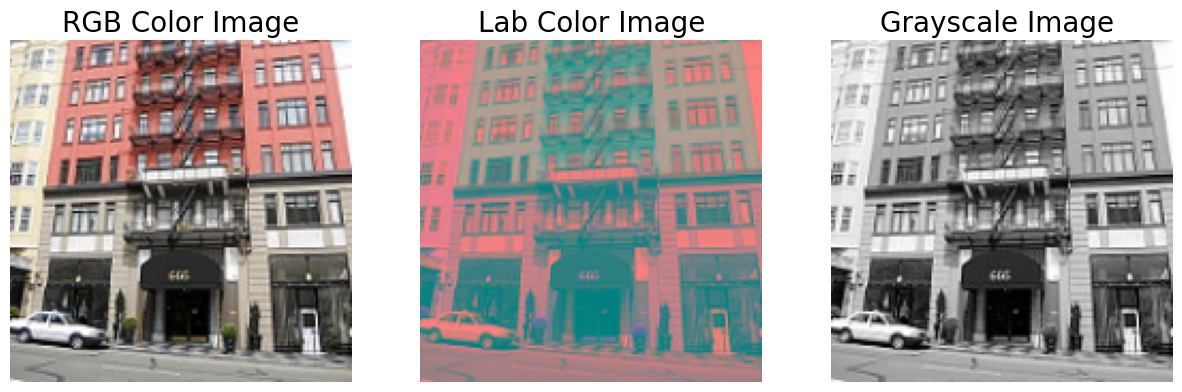

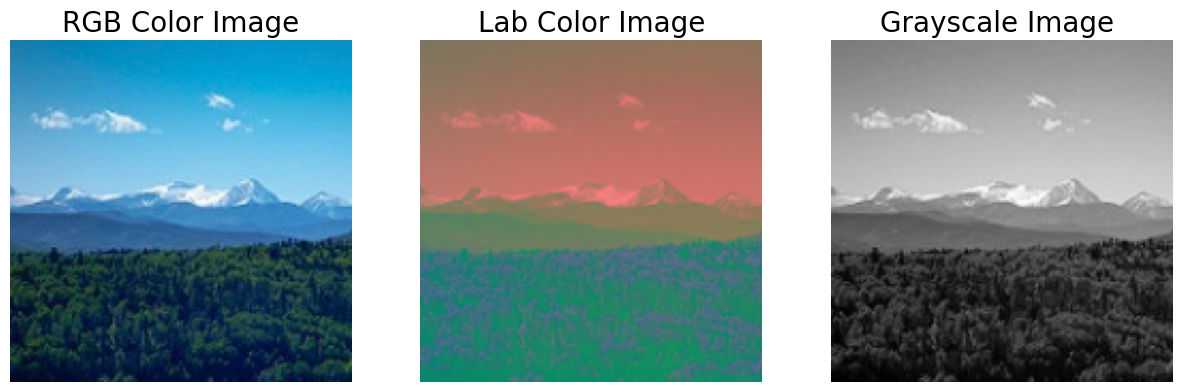

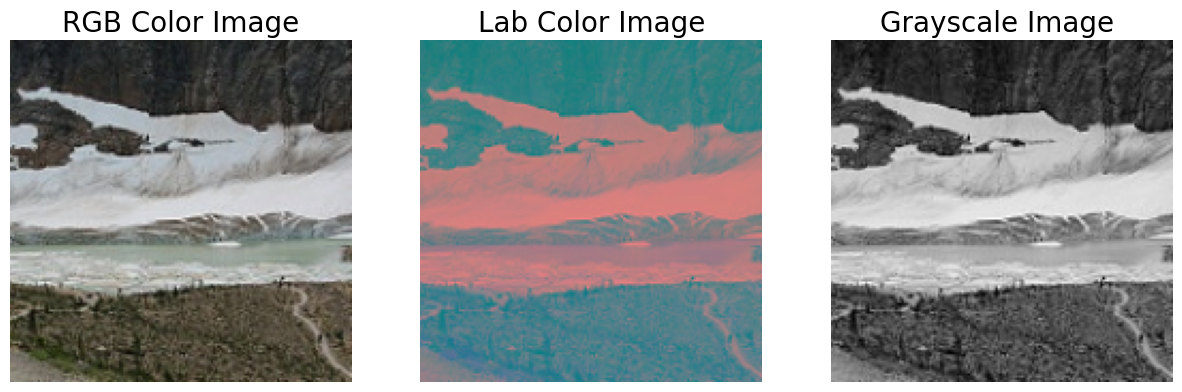

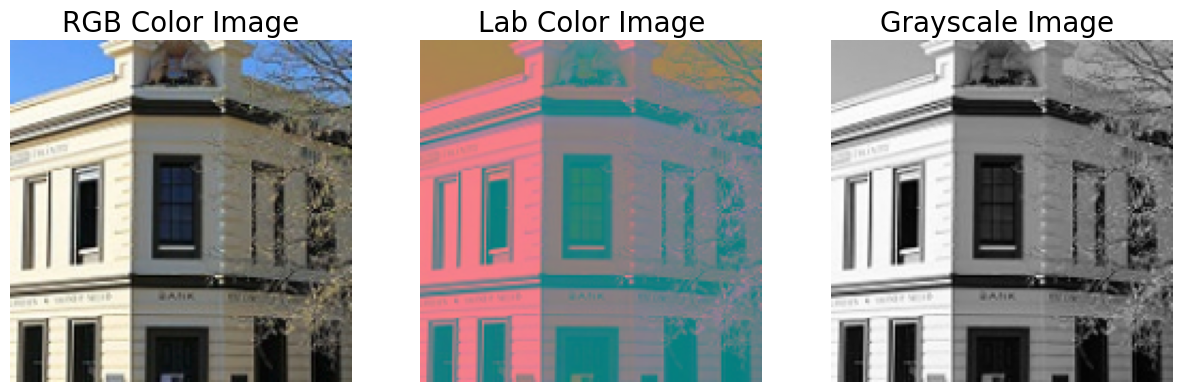

In [6]:
for _ in range(5):
    idx = np.random.randint(0, len(input_L) - 1)
    color_img = np.concatenate([input_L[idx] * 255, target_ab[idx] * 255], axis=2).astype(np.uint8)
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('RGB Color Image', fontsize=20)
    plt.imshow(np.clip(cv2.cvtColor(color_img, cv2.COLOR_LAB2RGB), 0, 255))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Lab Color Image', fontsize=20)
    plt.imshow(color_img)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Grayscale Image ', fontsize=20)
    plt.imshow((input_L[idx] * 255).astype(np.uint8).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

#### Split into training and test data

In [7]:
input_L = np.transpose(input_L, (0, 3, 1, 2)) # (N, 1, H, W)
target_ab = np.transpose(target_ab, (0, 3, 1, 2)) # (N, 2, H, W)
L_train, L_test, ab_train, ab_test = train_test_split(input_L, target_ab, test_size=0.2, random_state=42)
del input_L, target_ab
L_train = torch.tensor(L_train, dtype=torch.float32)
ab_train = torch.tensor(ab_train, dtype=torch.float32)
L_test = torch.tensor(L_test, dtype=torch.float32)
ab_test = torch.tensor(ab_test, dtype=torch.float32)

In [8]:
print(L_train.shape, ab_train.shape)
print(L_test.shape, ab_test.shape)

torch.Size([5703, 1, 160, 160]) torch.Size([5703, 2, 160, 160])
torch.Size([1426, 1, 160, 160]) torch.Size([1426, 2, 160, 160])


In [9]:
L_mean = L_train.mean(dim=(0, 2, 3))
L_std = L_train.std(dim=(0, 2, 3))
ab_mean = ab_train.mean(dim=(0, 2, 3))
ab_std = ab_train.std(dim=(0, 2, 3))

In [10]:
print(L_mean, L_std)
print(ab_mean, ab_std)

tensor([0.4738]) tensor([0.2587])
tensor([0.4963, 0.5037]) tensor([0.0346, 0.0710])


In [11]:
def unstandardize(tensor, mean, std):
    og_shape = tensor.shape
    C, H, W = og_shape[-3:]
    tensor = (tensor.reshape(-1, C, H, W) * std.reshape(1, C, 1, 1) + mean.reshape(1, C, 1, 1)).clamp(0, 1)  # unnormalize to [0, 1]
    return tensor.reshape(og_shape)  # restore original shape

def compute_ab_prior(dataloader):
    hist = torch.zeros(313)
    total = 0
    for _, labels in dataloader:
        hist += torch.bincount(labels.reshape(-1), minlength=313)  # accumulate histogram
        total += labels.numel()
        del labels
    return hist / total # p(c)

def make_rebalancing_weights(priors, alpha=0.5):
    C = priors.size(0)
    uniform = torch.full_like(priors, 1.0 / C, device=device)
    smoothed = (1.0 - alpha) * uniform + alpha * priors
    weights = 1.0 / smoothed # inverse of smoothed priors (Cross entropies) [0..inf]
    return weights / weights.mean()

def lab_to_rgb(x):
    lab = x.permute(1, 2, 0)
    L = (lab[:, :, 0] * 255).cpu().numpy().astype(np.uint8)
    a = (lab[:, :, 1] * 255).cpu().numpy().astype(np.uint8)
    b = (lab[:, :, 2] * 255).cpu().numpy().astype(np.uint8)
    lab_cv = np.stack([L, a, b], axis=2)
    rgb = cv2.cvtColor(lab_cv, cv2.COLOR_LAB2RGB)
    return rgb

In [12]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, L_data, ab_data, lut, ab_mean, ab_std, L_transform=None, ab_transform=None):
        self.L_data = L_transform(L_data) if L_transform else L_data
        ab_data = ab_transform(ab_data) if ab_transform else ab_data
        lut = lut.cpu()
        ab_mean = ab_mean.cpu().reshape(2, 1, 1)
        ab_std = ab_std.cpu().reshape(2, 1, 1)
        with torch.no_grad():
            ab = unstandardize(ab_data, ab_mean, ab_std) * 255.0
            a = ab[:, 0, :, :].long()
            b = ab[:, 1, :, :].long()
            idx = (a * 256 + b).reshape(a.size(0), -1)
            labels = lut[idx]
            self.labels = labels.reshape_as(a)
        del ab_data, ab, a, b, idx, labels, lut, ab_mean, ab_std
    def __len__(self):
        return self.L_data.size(0)

    def __getitem__(self, idx):
        return self.L_data[idx], self.labels[idx]

In [13]:
class CUDAPrefetcher:
    def __init__(self, loader):
        self.loader = iter(loader)
        self.stream = torch.cuda.Stream()
        self.next_L = None
        self.next_labels = None
        self._preload()

    def _preload(self):
        try:
            self.next_L, self.next_labels = next(self.loader)
        except StopIteration:
            self.next_L = None
            return
        with torch.cuda.stream(self.stream):
            self.next_L = self.next_L.to(device, memory_format=torch.channels_last, non_blocking=True) # if .half() the net
            self.next_labels = self.next_labels.to(device, non_blocking=True)

    def next(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        L, labels = self.next_L, self.next_labels
        self._preload()
        return L, labels

## Training pipeline

In [14]:
cluster_path = '../data/pts_in_hull.npy'
assert os.path.exists(cluster_path), "Download pts_in_hull.npy and place next to this script"
cluster_centers = torch.from_numpy(np.load(cluster_path)).float() # (313, 2) [-128..127]
cc_l2 = (cluster_centers ** 2).sum(dim=1) # (313,)
lut_coords  = (((torch.stack(torch.meshgrid(torch.arange(256), torch.arange(256), indexing='xy'), dim=-1).float()) - 128.0)
               .reshape(-1, 2)) # (65536, 2) [-128..127]

def compute_dist(tensor):
    dists = ((tensor ** 2).sum(dim=1, keepdim=True) # (B*H*W, 1)
             + cc_l2.reshape(1, -1) # (1, 313)
             - 2 * torch.matmul(tensor, cluster_centers.t())) # (B*H*W, 313)
    return dists

dists = compute_dist(lut_coords)
del lut_coords
lut = torch.argmin(dists, dim=1).long() # (65536,) [0..312] LUT for mapping (a, b) to cluster index
del dists

In [15]:
trainset = MyDataset(L_train, ab_train, lut, ab_mean, ab_std, L_transform=transforms.Normalize(mean=L_mean, std=L_std),
                     ab_transform=transforms.Normalize(mean=ab_mean, std=ab_std))
testset = MyDataset(L_test, ab_test, lut, ab_mean, ab_std, L_transform=transforms.Normalize(mean=L_mean, std=L_std),
                     ab_transform=transforms.Normalize(mean=ab_mean, std=ab_std))
del L_train, L_test, ab_train, ab_test # release memory

#### Early stopping used to stop training if model begins to overfit

In [16]:
def save_checkpoint(model, name='checkpoint'):
    torch.save(model.state_dict(), f"../models/{name}.pth")

class EarlyStopping:
    def __init__(self, patience=10, delta=5e-6):
        self.patience = patience
        self.counter = 0
        self.best_score = np.Inf
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, net):
        if self.best_score > val_loss:
            self.best_score = val_loss
            self.counter = 0
            save_checkpoint(net)
        elif self.best_score + self.delta < val_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

#### Rebalancing Weights Loss class

In [17]:
class RebalanceLoss(nn.Module):
    def __init__(self, weights):
        super(RebalanceLoss, self).__init__()
        self.register_buffer('class_weights', weights)
        self.loss_fn = nn.CrossEntropyLoss(weight=self.class_weights, reduction='mean')

    def forward(self, preds, labels):
        return self.loss_fn(preds, labels)

In [18]:
def fit(net, trainloader, optimizer, scaler, loss_fn, micro_size=64, acc_steps=4):
    net.train()
    total_loss, total_acc, count = torch.zeros(1, device=device), torch.zeros(1, device=device), 0
    optimizer.zero_grad(set_to_none=True)
    prefetcher = CUDAPrefetcher(trainloader)
    inputs, targets = prefetcher.next()
    micro_iter = 0
    while inputs is not None:
        for inp_mb, tar_mb in zip(inputs.chunk((inputs.size(0) + micro_size - 1) // micro_size, dim=0),
                                  targets.chunk((targets.size(0) + micro_size - 1) // micro_size,dim=0)):
            with torch.cuda.amp.autocast():
                out_mb = net(inp_mb)
                loss_mb = loss_fn(out_mb, tar_mb) # this goes OOM
                loss_scaled = loss_mb / acc_steps
            scaler.scale(loss_scaled).backward() # Error OOM because of ^
            with torch.no_grad():
                batch_size = tar_mb.size(0)
                total_loss += loss_mb.detach() * batch_size
                total_acc += out_mb.argmax(1).eq(tar_mb).sum()
                count += batch_size
            micro_iter += 1
            if micro_iter % acc_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
        inputs, targets = prefetcher.next()
    if micro_iter % acc_steps != 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    return (total_loss / count).item(), (total_acc / count).item()

@torch.inference_mode()
def predict(net, testloader, loss_fn, micro_size=64):
    net.eval()
    total_loss, total_acc, count = 0, 0, 0
    prefetcher = CUDAPrefetcher(testloader)
    inputs, targets = prefetcher.next()
    while inputs is not None:
        for inp_mb, tar_mb in zip(inputs.chunk((inputs.size(0) + micro_size - 1) // micro_size, dim=0),
                                  targets.chunk((targets.size(0) + micro_size - 1) // micro_size,dim=0)):
            with torch.cuda.amp.autocast():
                out_mb = net(inp_mb)
                loss_mb = loss_fn(out_mb, tar_mb)
            batch_size = tar_mb.size(0)
            total_loss += loss_mb.item() * batch_size
            total_acc += (out_mb.argmax(1) == tar_mb).sum().item()
            count += batch_size
        del inputs, targets
        inputs, targets = prefetcher.next()
    return total_loss / count, total_acc / count

#### Objective method for k fold cross validation

In [19]:
def objective(trial, trainset, scaler, X):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    coeff = trial.suggest_float('coeff', 0.0, 1.0, log=False)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_losses, mean_loss = [], 0
    val_loss, val_acc, val_topk_acc = 0, 0, 0
    split_n = 0
    prog_bar = tqdm(kf.split(X), desc="Splits", position=0)
    for train_idx, val_idx in prog_bar:
        split_n += 1
        trainloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx), num_workers=4, pin_memory=True, prefetch_factor=2)
        valloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(val_idx), num_workers=4, pin_memory=True, prefetch_factor=2)
        prior = compute_ab_prior(trainloader)
        weights = make_rebalancing_weights(prior, alpha=0.5)
        criterion = RebalanceLoss(lut, weights)
        del train_idx, val_idx, prior, weights
        net = Net().to(device, memory_format=torch.channels_last)
        optimizer = optim.Adam(net.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        for epoch in range(50):
            train_loss, train_acc = fit(net, trainloader, optimizer, scaler, criterion)
            val_loss, val_acc = predict(net, valloader, criterion)
            del ins, preds, truths
            scheduler.step(val_loss)
            prog_bar.set_description(
                f"Split {split_n} - Epoch {epoch + 1} |\nlr={lr:.3e}, batch size={batch_size:.3e}, coeff={coeff:.3e} |\n"
                f"Metrics train/val: Acc={train_acc:.3e}/{val_acc:.3e}, "
                f"Topk acc={val_topk_acc:.3e} |\nLoss: {train_loss:.3e}/{val_loss:.3e}")
            torch.cuda.empty_cache()
        del net, optimizer, scheduler
        val_losses.append(val_loss)
        mean_loss = np.mean(val_losses)
        trial.report(mean_loss, split_n)
        torch.cuda.empty_cache()
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return mean_loss

#### CAE NN definition

out = (in - kernel + 2 * pad) / stride + 1

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, 4, 2, 1)  # input is L only
        self.conv2 = nn.Conv2d(128, 128, 4, 2, 1)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.conv5 = nn.Conv2d(512, 512, 4, 2, 1)

        self.convt1 = nn.ConvTranspose2d(512, 512, 4, 2, 1)
        self.convt2 = nn.ConvTranspose2d(1024, 256, 4, 2, 1)
        self.convt3 = nn.ConvTranspose2d(512, 128, 4, 2, 1)
        self.convt4 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.convt5 = nn.ConvTranspose2d(256, 2, 4, 2, 1)  # output is ab (2 channels)

        self.bnorm1 = nn.BatchNorm2d(256)
        self.bnorm2 = nn.BatchNorm2d(512)
        self.bnorm3 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(0.2)
        self.lrelu = nn.LeakyReLU(inplace=True)
        self.classifier = nn.Conv2d(3, 313, 1, 1)  # concat u5 + x = (2+1)=3 -> 313 channels

    def forward(self, x): # x is (B, 1, H, W) => L channel
        d1 = self.lrelu(self.conv1(x)) # (B, 128, 80, 80)
        d2 = self.lrelu(self.conv2(d1)) # (B, 128, 40, 40)
        d3 = self.lrelu(self.bnorm1(self.conv3(d2))) # (B, 256, 20, 20)
        d4 = self.lrelu(self.bnorm2(self.conv4(d3))) # (B, 512, 10, 10)
        d5 = self.lrelu(self.bnorm3(self.conv5(d4))) # (B, 512, 5, 5)
        u1 = self.lrelu(self.convt1(d5)) # (B, 512, 10, 10)
        u1 = torch.cat([u1, d4], dim=1) # (B, 1024, 10, 10)
        u2 = self.lrelu(self.convt2(u1)) # (B, 256, 20, 20)
        u2 = torch.cat([u2, d3], dim=1) # (B, 512, 20, 20)
        u3 = self.lrelu(self.convt3(u2)) # (B, 128, 40, 40)
        u3 = torch.cat([u3, d2], dim=1) # (B, 256, 40, 40)
        u4 = self.lrelu(self.convt4(u3)) # (B, 128, 80, 80)
        u4 = torch.cat([u4, d1], dim=1) # (B, 256, 80, 80)
        u5 = self.lrelu(self.convt5(u4)) # (B, 2, 160, 160) — ab prediction
        u5 = torch.cat([u5, x], dim=1) # (B, 3, 160, 160)
        x = self.classifier(u5) # (B, 313, 160, 160)
        return x

In [25]:
writer = SummaryWriter('../runs')
net = Net().eval()
torch.quantization.fuse_modules(net, [
    ['conv3', 'bnorm1'],
    ['conv4', 'bnorm2'],
    ['conv5', 'bnorm3']
], inplace=True)
net = net.to(device, memory_format=torch.channels_last)
for m in net.modules():
    if isinstance(m, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
        m.weight = torch.nn.Parameter(m.weight.to(memory_format=torch.channels_last))
dummy = torch.zeros(1, 1, SIZE, SIZE).to(device, memory_format=torch.channels_last)
writer.add_graph(net, dummy)
writer.flush()
summary(net, input_data=dummy, col_names=('input_size', 'output_size', 'num_params', 'trainable'))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Net                                      [1, 1, 160, 160]          [1, 313, 160, 160]        --                        True
├─Conv2d: 1-1                            [1, 1, 160, 160]          [1, 128, 80, 80]          2,176                     True
├─LeakyReLU: 1-2                         [1, 128, 80, 80]          [1, 128, 80, 80]          --                        --
├─Conv2d: 1-3                            [1, 128, 80, 80]          [1, 128, 40, 40]          262,272                   True
├─LeakyReLU: 1-4                         [1, 128, 40, 40]          [1, 128, 40, 40]          --                        --
├─Conv2d: 1-5                            [1, 128, 40, 40]          [1, 256, 20, 20]          524,544                   True
├─Identity: 1-6                          [1, 256, 20, 20]          [1, 256, 20, 20]          --                        --
├─LeakyRe

Run command:\
tensorboard --logdir=runs\
Visible at http://localhost:6006/

#### Hyper parameter tuning

In [45]:
del dummy
gc.collect()
torch.cuda.empty_cache()

In [ ]:
X = np.zeros(len(trainset))
torch.cuda.empty_cache()
scaler = torch.cuda.amp.GradScaler()
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(lambda trial: objective(trial, trainset, scaler, X), n_trials=5)

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

#### Entire dataset

In [26]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True, prefetch_factor=None)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
optimizer = optim.AdamW(net.parameters(), lr=1e-3, fused=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
prior = compute_ab_prior(trainloader).to(device)
weights = make_rebalancing_weights(prior, alpha=0.5)
criterion = RebalanceLoss(weights).to(device, memory_format=torch.channels_last)
del prior, dummy

In [27]:
gc.collect()
torch.cuda.empty_cache()

Only for testing botttlenecks

In [24]:
import torch.autograd.profiler as prof

scaler = torch.cuda.amp.GradScaler()
with prof.profile(record_shapes=True, use_cuda=True) as p:
    with prof.record_function("train_step"):
        train_loss, train_acc = fit(net, trainloader, optimizer, scaler, criterion)
print(p.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             train_step        20.74%        4.607s        83.30%       18.501s       18.501s        8.416s        33.06%       17.064s       17.064s             1  
autograd::engine::evaluate_function: ConvolutionBack...         0.42%      92.586ms        12.47%        2.769s       2.797ms      18.191ms         0.07%        5.413s       5.468ms           990  
         

In [28]:
%matplotlib notebook
def update_plot():
    line1.set_data(range(len(train_losses)), train_losses)
    line2.set_data(range(len(test_losses)), test_losses)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()

In [29]:
torch.cuda.empty_cache()
early_stopping = EarlyStopping()
train_losses, train_accs = [], []
test_losses, test_accs, test_topk_accs = [], [], []
last_checkpoint = None
prog_bar = tqdm(range(50), total=50, desc='Training', position=0)

fig, ax = plt.subplots()
line1, = ax.plot([], [], label='Train Loss')
line2, = ax.plot([], [], label='Test Loss')
ax.legend()

scaler = torch.cuda.amp.GradScaler()
for epoch in prog_bar:
    train_loss, train_acc = fit(net, trainloader, optimizer, scaler, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_loss, test_acc = predict(net, testloader, criterion)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    scheduler.step(test_loss)
    early_stopping(test_loss, net)
    current_lr = optimizer.param_groups[0]['lr']
    prog_bar.set_description(f"Epoch {epoch + 1}, lr {current_lr} | Metrics train/val: Acc={train_acc:.3e}/{test_acc:.3e}, "
                             f"| Loss: {train_loss:.3e}/{test_loss:.3e}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    update_plot()
    torch.cuda.empty_cache()
    if early_stopping.early_stop:
        print("Early stopping")
        break
save_checkpoint(net, 'lastcheck')
writer.flush()

Training:   0%|          | 0/50 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [30]:
class ModelWithLoss(nn.Module):
    def __init__(self, net, loss_fn):
        super().__init__()
        self.net = net
        self.loss_fn = loss_fn

    def forward(self, x, y):
        preds = self.net(x)
        return self.loss_fn(preds, y)

## Evaluate results

To use NN:
rt = torch.jit.load("model_and_loss.pt")\
rt.eval()\
out = rt(input_tensor, target_tensor)

In [31]:
@torch.inference_mode()
def final_predict(net, testloader, loss_fn, micro_size=64):
    net.eval()
    total_loss, total_acc, count = 0, 0, 0
    ins, preds, truths = [], [], []
    prefetcher = CUDAPrefetcher(testloader)
    inputs, targets = prefetcher.next()
    while inputs is not None:
        for inp_mb, tar_mb in zip(inputs.chunk((inputs.size(0) + micro_size - 1) // micro_size, dim=0),
                                  targets.chunk((targets.size(0) + micro_size - 1) // micro_size,dim=0)):
            with torch.cuda.amp.autocast():
                out_mb = net(inp_mb)
                loss_mb = loss_fn(out_mb, tar_mb)
            if len(ins) <=1:
                ins.append(inp_mb.cpu())
                preds.append(out_mb.cpu())
                truths.append(tar_mb.cpu())
            batch_size = tar_mb.size(0)
            total_loss += loss_mb.item() * batch_size
            total_acc += (out_mb.argmax(1) == tar_mb).sum().item()
            count += batch_size
        del inputs, targets
        inputs, targets = prefetcher.next()
    return ins, preds, truths, total_loss / count, total_acc / count

In [35]:
net.load_state_dict(torch.load('../models/checkpoint.pth'))
ins, preds, truths, test_loss, test_acc = final_predict(net, testloader, criterion)
net_script = ModelWithLoss(net, RebalanceLoss(weights))
net_script = torch.jit.script(net_script)
net_script.save('../models/model_and_loss.pt')
net.load_state_dict(torch.load('../models/lastcheck.pth'))
ins2, preds2, truths2, loss2, acc2 = final_predict(net, testloader, criterion)

In [36]:
ins = torch.cat(ins, dim=0)
preds = torch.cat([cluster_centers[torch.argmax(pred, dim=1).reshape(-1)]
                  .reshape(pred.shape[0], pred.shape[2], pred.shape[3], 2)
                  .permute(0, 3, 1, 2) for pred in preds], dim=0)
truths = torch.cat([cluster_centers[torch.argmax(truth, dim=1).reshape(-1)]
                  .reshape(truth.shape[0], truth.shape[2], truth.shape[3], 2)
                  .permute(0, 3, 1, 2) for truth in truths], dim=0)

ins = [unstandardize(x, L_mean, L_std)for x in ins]
preds = [unstandardize(x, ab_mean, ab_std)for x in preds]
truths = [unstandardize(x, ab_mean, ab_std) for x in truths]

preds_rgb = [lab_to_rgb(torch.cat([L, ab], dim=0)) for L, ab in zip(ins, preds)]
truths_rgb = [lab_to_rgb(torch.cat([L, ab], dim=0)) for L, ab in zip(ins, truths)]

ins2 = torch.cat(ins2, dim=0)
preds2 = torch.cat(preds2, dim=0)
truths2 = torch.cat(truths2, dim=0)
ins2 = [unstandardize(x, L_mean, L_std)for x in ins2]
preds2 = [unstandardize(x, ab_mean, ab_std)for x in preds2]
truths2 = [unstandardize(x, ab_mean, ab_std) for x in truths2]
preds_rgb2 = [lab_to_rgb(torch.cat([L, ab], dim=0)) for L, ab in zip(ins2, preds2)]
truths_rgb2 = [lab_to_rgb(torch.cat([L, ab], dim=0)) for L, ab in zip(ins2, truths2)]

IndexError: tuple index out of range

In [ ]:
print(test_loss, test_acc)
print(loss2, acc2)

In [ ]:
%matplotlib inline

plt.figure()
plt.plot(train_accs, label='Train accuracy')
plt.plot(test_accs, label='Test accuracy')
plt.axhline(y=test_acc, color='g', linestyle='--')
plt.axhline(y=acc2, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.axhline(y=test_loss, color='g', linestyle='--')
plt.axhline(y=loss2, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(bottom=0)
plt.legend()
plt.show()

In [ ]:
for _ in range(5):
    idx = np.random.randint(0, len(ins))
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Gray Image', fontsize=20)
    plt.imshow(ins[idx].squeeze().cpu().numpy() , cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Predicted Image', fontsize=20)
    plt.imshow(preds_rgb[idx])  # Already a [H, W, 3] NumPy RGB image
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Groundtruth Image', fontsize=20)
    plt.imshow(truths_rgb[idx])  # Already a [H, W, 3] NumPy RGB image
    plt.axis('off')
    plt.show()